# The Use of Machine Learning in Treatment Effect Estimation

#### We use Double Machine Learning (DML) to estimate average and conditional treatment effects with flexible models for outcomes and treatment assignment.

#### Notation.  
#### Let $Y(1)$ be the potential outcome under treatment and $Y(0)$ the potential outcome under no treatment.  
#### Let $T \in \{ 0,1 \} $ be the binary treatment indicator and $X$ the vector of the covariates.  
#### The treatment effect for the covaiates $X = x \text{ is } \tau (x) = E[Y(1)-Y(0) | X=x]$.
#### The average treatment effect (ATE) is $ E [ Y(1) - Y(0)$. 
#### In the simulation below, the true heterogeneous effect is $\tau (X) = 2 X_1$. Since $ X_1 \approx $ 

In [3]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_text

import matplotlib.pyplot as plt

from econml.dml import DML

In [4]:
np.random.seed(123)

n = 1000
X = np.random.normal(0, 1, (n, 3))          # Covariates: X[:,0], X[:,1], X[:,2]
T = np.random.binomial(1, 0.5, n)           # Binary treatment

# Outcome with heterogeneity: tau(X) = 2 * X[:,0]
# Structural outcome: Y = tau(X)*T + f(X) + noise, where f(X) = X[:,1]
Y = 2 * T * X[:, 0] + X[:, 1] + np.random.normal(0, 1, n)

In [5]:
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(
    X, T, Y, test_size=0.2, random_state=42
)

In [6]:
model_y = RandomForestRegressor(n_estimators=200, random_state=42)
model_t = RandomForestClassifier(n_estimators=200, random_state=42)

In [7]:
# Final stage is a simple linear model on the learned signal
dml = DML(
    model_y=model_y,
    model_t=model_t,
    model_final=LinearRegression(fit_intercept=False),
    discrete_treatment=True,
    random_state=42
)

dml.fit(Y_train, T_train, X=X_train)

In [8]:
# DML returns pointwise effects; ATE is their mean over a target sample
cate_test = dml.effect(X_test)
ate_est = np.mean(cate_test)

print(f"Estimated ATE on test set: {ate_est:.4f}")

Estimated ATE on test set: -0.3083


In [9]:
print("First five CATE estimates:", np.round(cate_test[:5], 3))

First five CATE estimates: [-2.697 -2.881  1.711  0.476  0.667]


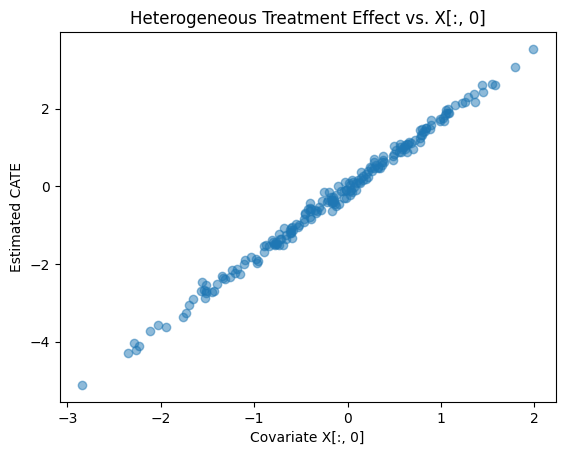

In [10]:
plt.scatter(X_test[:, 0], cate_test, alpha=0.5)
plt.xlabel('Covariate X[:, 0]')
plt.ylabel('Estimated CATE')
plt.title('Heterogeneous Treatment Effect vs. X[:, 0]')
plt.show()

In [11]:
# Fit a shallow tree to the (X, CATE) pairs to get human-readable splits
tree = DecisionTreeRegressor(max_depth=3, random_state=42)
tree.fit(X_test, cate_test)

rules = export_text(
    tree,
    feature_names=[f"X{j}" for j in range(X.shape[1])]
)
print("Decision rules from tree:\n", rules)

Decision rules from tree:
 |--- X0 <= -0.46
|   |--- X0 <= -1.25
|   |   |--- X0 <= -1.74
|   |   |   |--- value: [-4.01]
|   |   |--- X0 >  -1.74
|   |   |   |--- value: [-2.66]
|   |--- X0 >  -1.25
|   |   |--- X0 <= -0.90
|   |   |   |--- value: [-2.00]
|   |   |--- X0 >  -0.90
|   |   |   |--- value: [-1.27]
|--- X0 >  -0.46
|   |--- X0 <= 0.49
|   |   |--- X0 <= 0.05
|   |   |   |--- value: [-0.37]
|   |   |--- X0 >  0.05
|   |   |   |--- value: [0.38]
|   |--- X0 >  0.49
|   |   |--- X0 <= 1.04
|   |   |   |--- value: [1.25]
|   |   |--- X0 >  1.04
|   |   |   |--- value: [2.31]

